In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.optim as optim
import numpy.matlib
import imageio
#from skimage import measure
from PIL import Image
import math
import random
import os
from os import listdir
from os.path import isfile, join, isdir
import sys
import time
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
from IPython.display import clear_output

import cv2
import csv
import time

import subprocess
def imresize(arr,size, resample=0):
    
    if resample == Image.NEAREST:
        interpolation = cv2.INTER_NEAREST
    if resample == Image.LANCZOS:
        interpolation = cv2.INTER_LANCZOS4
    if resample == Image.BICUBIC:
        interpolation = cv2.INTER_CUBIC
    if resample == Image.LINEAR:
        interpolation = cv2.INTER_LINEAR

    size_ = size.copy()
    size_[1], size_[0] = size_[0],size_[1]
    #return np.array(Image.fromarray(arr).resize(size_, resample))
    return cv2.resize(arr,(size[1],size[0]),interpolation=interpolation)

def crop2shape(img,index_x=None,index_y=None):
    
    if len(img.shape) == 3:
        if index_x is None:
            proj_x = img.min(axis=0).min(axis=1)
            index_y = np.where(255>proj_x)
            proj_y = img.min(axis=1).min(axis=1)
            index_x = np.where(255>proj_y)
        return img[index_x[0][0]:index_x[0][-1],index_y[0][0]:index_y[0][-1],:],index_x,index_y
    if index_x is None:
            proj_x = img.min(axis=0)
            index_y = np.where(255>proj_x)
            proj_y = img.min(axis=1)
            index_x = np.where(255>proj_y)
    return img[index_x[0][0]:index_x[0][-1],index_y[0][0]:index_y[0][-1]],index_x,index_y
  
    
def cb_img(imgA,imgB):
    cb = np.zeros(imgA.shape+(3,))
    x = np.arange(0, cb.shape[1], 1)
    y = np.arange(0, cb.shape[0], 1)
    xx, yy = np.meshgrid(x, y, sparse=False)

    w = 200
    mask1 = np.logical_or((xx//w)%2 == 0 ,(yy//w)%2 == 0)
    mask2 = np.logical_and((xx//w)%2 == 0 ,(yy//w)%2 == 0)
    mask = np.logical_xor(mask1,mask2)
    cb[mask,:] = imgA[mask,None]
    cb[np.logical_not(mask),:] = (1-(imgB[np.logical_not(mask),:]))**1.2
    return cb
#plt.imshow(crop2shape(img))

print("ok")

Random Seed:  999
ok


In [2]:
# Root directory for dataset
#dataroot = "project/domain_trafo"
# Number of workers for dataloader
#workers = 1
# Batch size during training


# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64

# Number of channels in the training images. For color images this is 3
#nc = 3

# Number of training epochs
#num_epochs = 5

# Learning rate for optimizers
#lr = 0.0002

# Beta1 hyperparam for Adam optimizers
#beta1 = 0.5

In [3]:


#!mkdir /home/skibbe/projects/domain_trafo/akiya_backlit/

In [4]:

#################
# data with labeles
#################

db_folder = '/home/skibbe/projects/domain_trafo/data2/'
pt_files = [f for f in listdir(join(db_folder,'tc/')) if (isfile(join(db_folder,'tc/',f)) and ("png" in f) and ("png" in f))] 

print(len(pt_files))
img_in = []
img_out = []
img_labels = []

count = 0
for fn in pt_files:
    nissl_img,index_x,index_y = crop2shape(imageio.imread(db_folder+"bl/"+fn))
    tc_img,_,_ = crop2shape(imageio.imread(db_folder+"tc/"+fn),index_x,index_y)
    img_in += [torch.tensor(nissl_img)[None,:,:].type(torch.FloatTensor)]
    img_out += [torch.tensor(tc_img)[None,:,:].type(torch.FloatTensor)]
    img_labels += [1]
    count += 1
    if count % 200 == 0:
        print("with labels: {} {}".format(count,len(pt_files)))
        
#data without labeles        
db_folder2 = '/home/skibbe/projects/domain_trafo/akiya_backlit/'
pt_files = [f for f in listdir(db_folder2) if (isfile(join(db_folder2,f)) and ("jpg" in f))]         
print(len(pt_files))
for fn in pt_files:#[:10]:

    nissl_img,_,_ = crop2shape(imageio.imread(join(db_folder2,fn)))
    img_in += [torch.tensor(nissl_img)[None,:,:].type(torch.FloatTensor)]    
    img_out += [torch.zeros([1,img_in[-1].shape[1],img_in[-1].shape[2]]).type(torch.FloatTensor)]
    img_labels += [0]
    count += 1
    if count % 200 == 0:
        print("without labels: {} {}".format(count,len(pt_files)))        

3065
with labels: 200 3065
with labels: 400 3065
with labels: 600 3065
with labels: 800 3065
with labels: 1000 3065
with labels: 1200 3065
with labels: 1400 3065
with labels: 1600 3065
with labels: 1800 3065
with labels: 2000 3065
with labels: 2200 3065
with labels: 2400 3065
with labels: 2600 3065
with labels: 2800 3065
with labels: 3000 3065
1091
without labels: 3200 1091
without labels: 3400 1091
without labels: 3600 1091
without labels: 3800 1091
without labels: 4000 1091


In [ ]:
#nissl_img
#count
#plt.imshow(img_in[-1].permute([1,2,0])/255)
#img_in[-1]
#img_in[-1].max()
#bla = imageio.imread(db_folder+"bl/"+fn)
#bla.shape
#nissl_img,index_x,index_y = crop2shape(bla)
#bla = imageio.imread(db_folder+"bl/"+fn))##

In [5]:
#################################
#  Data loader with  augmentation
#################################


class MyData(Dataset):

    def __init__(self, input_imgs, label_imgs, has_labels, transform_in=None,
                                                 transform=None):
        
        self.input_imgs = input_imgs
        self.label_imgs = label_imgs
        self.has_labels = has_labels
        
        self.transform = transform
        self.transform_in = transform_in

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img, has_label = self.input_imgs[idx], self.label_imgs[idx], self.has_labels[idx]
        
        angle = -10 + random.random() * 20
        translate = [-10 + random.random() * 20,-10 + random.random() * 20]
        scale = 0.5 + random.random()*0.7
        shear = [-5 + random.random()*5, -5 + random.random()*5]
        
        fillcolor = int(img_in[0][0,0,0])
        
        int_fact = 0.5 + 0.5 * random.random()
        trafo_bright = lambda x: x*int_fact
        gamma = 0.75 + 0.5 * random.random()
        trafo_gamma = lambda x: x**gamma
        cf = random.random() * 0.15
        cf2 = random.random() * 0.15
        trafo_clamp = lambda x : torch.clamp((x-cf)/(1-cf-cf2),min=0.0,max=1.0)

        return self.transform_in(self.transform(trafo_clamp(trafo_gamma(trafo_bright(
            transforms.ToTensor()(transforms.functional.affine(transforms.ToPILImage()(input_img.type(torch.uint8)), angle=angle, 
                                                      translate=translate, scale=scale, shear=shear, fillcolor=(fillcolor))))))
        )), self.transform(
            transforms.functional.affine(label_img, angle=angle, 
                                                      translate=translate, scale=scale, shear=shear, fillcolor=[0])
            
        ), has_label


class Norm01(object):
    def __init__(self):
        pass
    def __call__(self, input):
            A = input.clone()
            maxv = A.min()
            A -= maxv
            maxv = A.max()
            if maxv>0.000001:
                A /= maxv
            return A

  


In [17]:
f = lambda x:torch.nn.functional.interpolate(x, size=None, scale_factor=0.5, mode='nearest', align_corners=None, recompute_scale_factor=None) 
f(inputs).shape                                       

torch.Size([25, 3, 256, 256])

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class ResBlock(nn.Module):
    def __init__(self, input_channels=3,
                         output_channels=3,
                         btype='same',
                         norm=nn.InstanceNorm2d,
                         output_fun = nn.LeakyReLU,
                        dropouts=0.5):
        super(ResBlock, self).__init__()
        self.btype = btype 
        if btype == 'same':
            if dropouts >0:
                self.main = nn.Sequential(nn.Conv2d( input_channels,output_channels , 3, 1, 1, bias=False,padding_mode='replicate'),
                                  norm(output_channels),
                                  nn.LeakyReLU(inplace=True),
                                  nn.Conv2d( output_channels,output_channels , 3, 1, 1, bias=False,padding_mode='replicate'),
                                  nn.Dropout2d(dropouts),  
                                  norm(output_channels),                                                
                                )
            else:
                self.main = nn.Sequential(nn.Conv2d( input_channels,output_channels , 3, 1, 1, bias=False,padding_mode='replicate'),
                                  norm(output_channels),
                                  nn.LeakyReLU(inplace=True),          
                                  nn.Conv2d( output_channels,output_channels , 3, 1, 1, bias=False,padding_mode='replicate'),
                                  norm(output_channels))

            self.skip = nn.Sequential(nn.Conv2d( input_channels,output_channels , 1, 1, 0, bias=False),
                                      norm(output_channels),
                                     )
        if btype == 'down':
            self.main = nn.Sequential(nn.Conv2d( input_channels,output_channels , 2, 2, 0, bias=False,padding_mode='replicate'),
                              norm(output_channels),
                              nn.LeakyReLU(inplace=True),
                              )

        if btype == 'up':
            self.main = nn.Sequential(
                              nn.ConvTranspose2d( input_channels,output_channels , 2, 2, 0, bias=False),
                              norm(output_channels),
                              nn.LeakyReLU(inplace=True))

        self.out = output_fun()

    def forward(self, input):
        y = self.main(input)
        if self.btype == 'same':
            return self.out(y+self.skip(input))
        return self.out(y)

In [25]:
class Generator(nn.Module):
    #def __init__(self, input_channels=3,output_channels=1,depth = 3,feat_fun=lambda x,d:x*2**d):
    def __init__(self, input_channels=3,output_channels=1,depth = 3,noskip=[],feat_fun=lambda x,d:x*2**d):
        super(Generator, self).__init__()
        self.main = nn.ModuleDict()
        self.depth = depth
        self.noskip = noskip
        self.init = True
        feats = 8
        for d in range(depth+1):
            self.main['enc'+str(d)] =  ResBlock(input_channels if d == 0 else feat_fun(feats,d),feat_fun(feats,d),'same',nn.InstanceNorm2d if d == 0  else nn.BatchNorm2d,nn.LeakyReLU)                

            self.main['dec'+str(d)] =  ResBlock((1 if d in noskip else 2)*feat_fun(feats,d),feat_fun(feats,d),'same', nn.BatchNorm2d,nn.LeakyReLU,dropouts=0)                

            if d < depth:
                self.main['down'+str(d)] = ResBlock(feat_fun(feats,d),feat_fun(feats,d+1),'down',nn.InstanceNorm2d,nn.LeakyReLU)
            if d > 0:
                self.main['up'+str(d)] = ResBlock(feat_fun(feats,d),feat_fun(feats,d-1),'up',nn.InstanceNorm2d,nn.LeakyReLU)
       
        self.main['out'] = nn.Conv2d( feats,output_channels , 1, 1, 0, bias=True)
        
    def forward(self, inputs):
        depth = self.depth
        Y = {}
        y = inputs
        if True:
            for d in range(depth+1):
                Y[str(d)] = self.main['enc'+str(d)](y)
                if d < depth:
                    y = self.main['down'+str(d)](Y[str(d)])
                else:
                    y = Y[str(d)]
                
        if True:
            for d in range(depth-1,-1,-1):
                y = self.main['up'+str(d+1)](y)
                
                if d in self.noskip:
                    y = self.main['dec'+str(d)](y)      
                    if self.init:
                        print("{} no skip".format(d))
                else:
                    y = self.main['dec'+str(d)](torch.cat((Y[str(d)],y),dim=1))
                    if self.init:
                        print("{} adding skip".format(d))
        y = self.main['out'](y)
        self.init = False
        return y
        
class GeneratorSupervised(nn.Module):
    def __init__(self, input_channels=3):
        super(GeneratorSupervised, self).__init__()
        fests_ = [8,16,16,16,16]
        self.supervised = Generator(input_channels,depth = 4,feat_fun=lambda x,d:fests_[d],noskip=[0])
    def forward(self, input):
        y = self.supervised(input)
        return nn.Tanh()(y)
    
    
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print("ok")


ok


In [8]:
#netG.main["enc0"]

In [20]:

class Discriminator(nn.Module):
    def __init__(self,shape,input_channels = 1):
        super(Discriminator, self).__init__()
        
        self.main = nn.ModuleDict()
        feats0 = 8
        feats1 = feats0 * 2
        feats2 = feats1 * 2
        feats3 = feats2 * 2
        feats4 = feats3 * 2
        
        print("shape in {}".format(shape))
        shape_conv = (torch.tensor(shape)/2**5).type(torch.int32)
        print("shape conv {}".format(shape_conv))
 
        if True:
            self.main['main'] =  nn.Sequential(
                        torch.nn.utils.spectral_norm(nn.Conv2d( input_channels,feats0 , 4, 2, 1, bias=True)),
                        nn.LeakyReLU(inplace=True),
                        #
                        torch.nn.utils.spectral_norm(nn.Conv2d( feats0,feats1 , 4, 2, 1, bias=True)),
                        nn.LeakyReLU(inplace=True),
                        #
                        torch.nn.utils.spectral_norm(nn.Conv2d( feats1,feats2 , 4, 2, 1, bias=True)),
                        nn.LeakyReLU(inplace=True),
                        #
                        torch.nn.utils.spectral_norm(nn.Conv2d( feats2,feats3 , 4, 2, 1, bias=True)),
                        nn.LeakyReLU(inplace=True),
                        #
                        torch.nn.utils.spectral_norm(nn.Conv2d( feats3,feats4 , 4, 2, 1, bias=True)),
                        nn.LeakyReLU(inplace=True),
                        #
                        torch.nn.utils.spectral_norm(nn.Conv2d( feats4,1 , tuple(shape_conv), 1, 0, bias=True)),
                        nn.Sigmoid()
                    )       
        
    def forward(self, input):
        y = self.main['main'](input)
       
        return y 

print("ok")

ok


In [24]:
#feats1=1
#feats0=1
#nn.ConvTranspose2d( feats1,feats0 , 3, 2, 1, bias=False)

ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [ ]:
model = './models/SemiGAN_semisupervised_BACKLIT_model.tar'

# based on the pytorch GAN tutorial (Nathan Inkawhich):
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
batch_size = 25


dshape = [512,512]


my_transforms = transforms.Compose([
    Norm01(),
    transforms.Resize(dshape),
])

my_transforms_in = transforms.Compose([
])

data = MyData(img_in[::2],img_out[::2],img_labels[::2],my_transforms_in,my_transforms)  
real_label = 1.
fake_label = 0.

netG = GeneratorSupervised(1).to(device)
netG.apply(weights_init)

netD = Discriminator(dshape,2).to(device)
netD.apply(weights_init)

lr = 0.0002

optimizerG = optim.Adam(netG.parameters(), lr=lr)
optimizerD = optim.Adam(netD.parameters(), lr=lr)


dataloader = DataLoader(data, batch_size=batch_size,
                                         shuffle=True)



mpl.rcParams['figure.dpi']


img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 1000000000
torch.autograd.set_detect_anomaly(True)
criterion_supervised = nn.MSELoss()
criterion_dis = nn.BCELoss()

print("Starting Training Loop...")
if device != 'cpu':
    netG.cuda()


if False:
    checkpoint = torch.load(model)
    netG.load_state_dict(checkpoint['netG'])
    netD.load_state_dict(checkpoint['netD'])
    optimizerD.load_state_dict(checkpoint['optimizerD'])
    optimizerG.load_state_dict(checkpoint['optimizerG'])
    iters = checkpoint['iter']
    epoch = checkpoint['epoch']

print("done")

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        inputs = data[0].to(device=device)
        labels = data[1].to(device=device)
        has_labels = data[2].to(device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        valid_labels = has_labels>0#np.array(has_labels)>0

        
        real_cpu = labels
        
        netD.zero_grad()
        b_size = real_cpu.size(0)
        
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)    
        # Forward pass real batch through D
        
        
        dist_input = torch.cat((inputs[valid_labels,::],real_cpu[valid_labels,::]),dim=1)
        output = netD(dist_input).view(-1)
                      
        # Calculate loss on all-real batch
        errD_real = criterion_dis(output, label[valid_labels])
            
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        fake = netG(inputs)
        
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        dist_input = torch.cat((inputs,fake.detach()),dim=1) 
        output = netD(dist_input).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion_dis(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        #print("7")
       
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        dist_input = torch.cat((inputs,fake),dim=1) 
        output = netD(dist_input).view(-1)

        # Calculate G's loss based on this output
        errG_unsupervised = criterion_dis(output, label)
        
        # Supervised loss
        errG_supervised = criterion_supervised(fake[valid_labels,::], labels[valid_labels])        
        errG = errG_unsupervised + errG_supervised
        
        # Calculate gradients for G
        errG.backward()
        
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()      
        
        
        if iters % 200 == 0:
            torch.save({
                        'epoch': epoch,
                        'iter':iters,
                        'netG': netG.state_dict(),
                        'netD': netD.state_dict(),
                        'optimizerD': optimizerD.state_dict(),
                        'optimizerG': optimizerG.state_dict(),
                        }, model)
        plt.pause(0.1)
        if iters % 10 == 0:
            clear_output(wait=True)
            print('[{}/{}][{}/{}]\tLoss_G: {} | usv {} sv {}'.format(epoch, num_epochs, i, len(dataloader),errG.item(),errG_unsupervised,errG_supervised))

            mpl.rcParams['figure.dpi'] = 300
            imgA = inputs[0,:,:,:].permute([1,2,0]).cpu().detach().numpy()
            imgB = fake[0,0,:,:].cpu().detach().numpy()

            f = plt.figure()
            ax = f.gca()
            ax = plt.subplot(1,4,1)
            ax.imshow(imgA)
            ax = plt.subplot(1,4,2)
            cb = cb_img(imgB,imgA)
            ax.imshow(cb)
            ax = plt.subplot(1,4,3)
            ax.imshow(imgB, cmap='gray')
            ax = plt.subplot(1,4,4)
            ax.imshow(labels[0,0,:,:].cpu().detach().numpy(), cmap='gray')
            
            plt.pause(0.1)
            ax.axis('off')

        iters += 1
print("done")        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[319/1000000000][24/84]	Loss_G: 1.635645866394043 | usv 1.6296415328979492 sv 0.0060043297708034515


In [50]:
#!mv ./models/semi_supervised_SemiGAN_backlit.tar ./models/semi_supervised_SemiGAN_backlit_skip012.tar

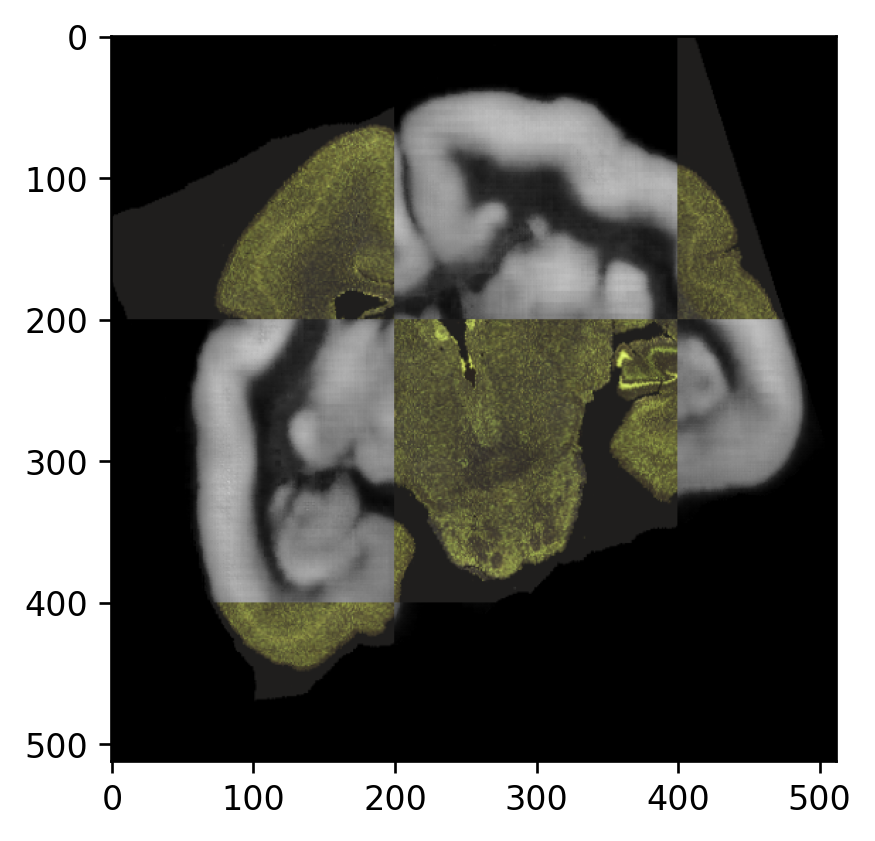

In [159]:
def cb_img(imgA,imgB):
    cb = np.zeros(imgA.shape+(3,))
    x = np.arange(0, cb.shape[1], 1)
    y = np.arange(0, cb.shape[0], 1)
    xx, yy = np.meshgrid(x, y, sparse=False)

    w = 200
    mask1 = np.logical_or((xx//w)%2 == 0 ,(yy//w)%2 == 0)
    mask2 = np.logical_and((xx//w)%2 == 0 ,(yy//w)%2 == 0)
    mask = np.logical_xor(mask1,mask2)
    cb[mask,:] = imgA[mask,None]
    cb[np.logical_not(mask),:] = (1-(imgB[np.logical_not(mask),:]))**1.2
    return cb
    #plt.imshow(cb)
    #plt.pause(0.1)

imgA = inputs[0,:,:,:].permute([1,2,0]).cpu().detach().numpy()
imgB = fake[0,0,:,:].cpu().detach().numpy()
cb = cb_img(imgB,imgA)
plt.imshow(cb)

In [8]:
if False:
    torch.save({
                        'epoch': epoch,
                        'iter':iters,
                        'netG': netG.state_dict(),
                        'netD': netD.state_dict(),
                        'optimizerD': optimizerD.state_dict(),
                        'optimizerG': optimizerG.state_dict(),
                        }, './models/supervised_gan.tar')